In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [2]:
df=pd.read_csv('mortgage_dataset4.csv')

In [3]:
df.head()

,record_date,mortgage_rate,consumer_goods_production,cpi,household_net_worth,industrial_production,rates_3months,job_openings,money_supply,money_velocity,3monthForecast,6monthForecast,12monthForecast
0,2001-01,7.0325,103.0259,175.6,41994416,91.8903,5.62,5234,4981.02,2.085,7.0775,7.1275,6.9975
1,2001-04,7.0775,102.6877,176.4,43198401,90.7293,4.53,4615,5167.06,2.059,7.1275,6.6175,6.9850
2,2001-07,7.1275,102.2020,177.4,42164052,89.2260,3.66,4447,5182.80,2.014,6.6175,6.9975,6.4850
3,2001-10,6.6175,102.4001,177.6,43746475,88.3926,2.31,3707,5316.20,1.980,6.9975,6.9850,6.1125
4,2002-01,6.9975,103.8754,177.7,44391512,88.4665,1.74,3699,5455.30,1.969,6.9850,6.4850,5.9160


In [7]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df[['3monthForecast']])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.662719
p-value: 0.450416


In [8]:
model_3m = pm.auto_arima(df["3monthForecast"], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=144.684, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=126.145, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=142.692, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=120.260, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=111.131, Time=0.12 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=109.184, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=118.274, Time=0.21 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=102.287, Time=0.23 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=100.363, Time=0.22 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=98.363, Time=0.31 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=96.824, Time=0.09 sec


In [5]:
print(model_3m.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   90
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 -46.412
Date:                Sun, 26 Nov 2023   AIC                             96.824
Time:                        16:56:32   BIC                            101.778
Sample:                             0   HQIC                            98.820
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9372      0.038    -24.419      0.000      -1.012      -0.862
sigma2         0.1641      0.016     10.129      0.000       0.132       0.196
Ljung-Box (L1) (Q):                   0.21   Jarque-

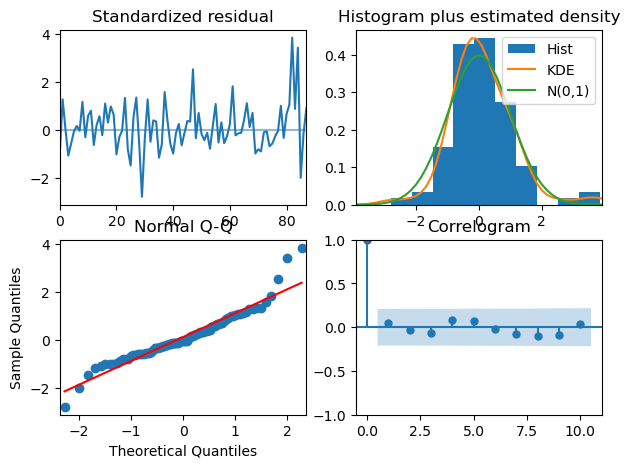

In [6]:
model_3m.plot_diagnostics(figsize=(7,5))
plt.show()

In [9]:
from statsmodels.graphics.tsaplots import plot_predict
mod= ARIMA(df["3monthForecast"], order=(0, 2, 1))
model_fit=mod.fit()
#print(model_fit.summary())
n=len(df["3monthForecast"])
predicted=model_fit.predict()
df["Actual"]=df["3monthForecast"]
df["Forecast"]=list(predicted)

<Axes: title={'center': 'ARIMA'}>

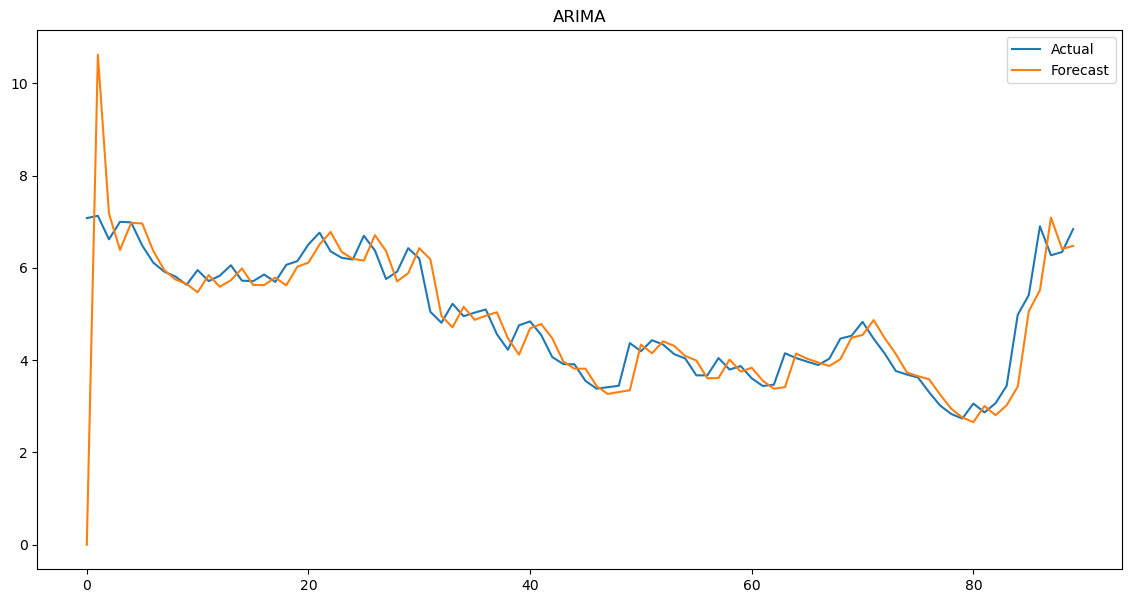

In [14]:
df[["Actual","Forecast"]].plot(title='ARIMA',figsize=(14, 7))


In [12]:
# Accuracy metrics
import numpy as np
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    mse = np.mean((forecast - actual)**2)  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'mse':mse,  
            'corr':corr, 'minmax':minmax})

forecast_accuracy(df['Forecast'], df['Actual'])

C:\Users\anvpr\AppData\Local\Temp\ipykernel_14480\3619457827.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
C:\Users\anvpr\AppData\Local\Temp\ipykernel_14480\3619457827.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\anvpr\AppData\Local\Temp\ipykernel_14480\3619457827.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
C:\Users\anvpr\AppData\Local\Temp\ipykernel_14480\3619457827.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `o

{'mape': 0.07623814334380523,
 'me': -0.0815047433145822,
 'mae': 0.40787537745274555,
 'mpe': -0.012278417906137004,
 'mse': 0.8560428743321067,
 'corr': 0.773370898972484,
 'minmax': 0.07242616718704431}

In [29]:
model_6m = pm.auto_arima(df["6monthForecast"], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=143.675, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=126.631, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=141.732, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=122.016, Time=0.12 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=110.444, Time=0.17 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=108.547, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=120.106, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=102.778, Time=0.20 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=101.754, Time=0.20 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=99.818, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=98.252, Time=0.08 sec


In [30]:
mod= ARIMA(df["6monthForecast"], order=(0, 2, 1))
model6m_fit=mod.fit()
#print(model_fit.summary())
n=len(df["6monthForecast"])
predicted=model6m_fit.predict()
df["Actual6m"]=df["6monthForecast"]
df["predicted6m"]=list(predicted)

In [13]:
df[["Actual6m","predicted6m"]].plot(title='ARIMA',figsize=(14, 7))

KeyError: "None of [Index(['Actual6m', 'predicted6m'], dtype='object')] are in the [columns]"

In [28]:
forecast_accuracy(df['predicted6m'], df['Actual6m'])

C:\Users\anvpr\AppData\Local\Temp\ipykernel_3404\1388768744.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
C:\Users\anvpr\AppData\Local\Temp\ipykernel_3404\1388768744.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\anvpr\AppData\Local\Temp\ipykernel_3404\1388768744.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
C:\Users\anvpr\AppData\Local\Temp\ipykernel_3404\1388768744.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:

{'mape': 0.07811498698500177,
 'me': -0.08877220636018235,
 'mae': 0.41857030465818323,
 'mpe': -0.012900958510919875,
 'rmse': 0.9578119953027648,
 'corr': 0.757703125497101,
 'minmax': 0.07350314153522486}

In [33]:
model_12m = pm.auto_arima(df["12monthForecast"][:-2], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=139.224, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=122.046, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=137.244, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=118.154, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=107.197, Time=0.17 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=105.331, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=116.261, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=100.019, Time=0.20 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=98.965, Time=0.22 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=96.975, Time=0.16 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=95.542, Time=0.11 sec
 

In [42]:
forecast=df["12monthForecast"][:-2]
mod= ARIMA(forecast, order=(0, 2, 1))
model12m_fit=mod.fit()
#print(model_fit.summary())
predicted=model12m_fit.predict()
df2=pd.DataFrame()
df2["Actual12m"]=df["12monthForecast"][:-2]
df2["predicted12m"]=list(predicted)

<Axes: >

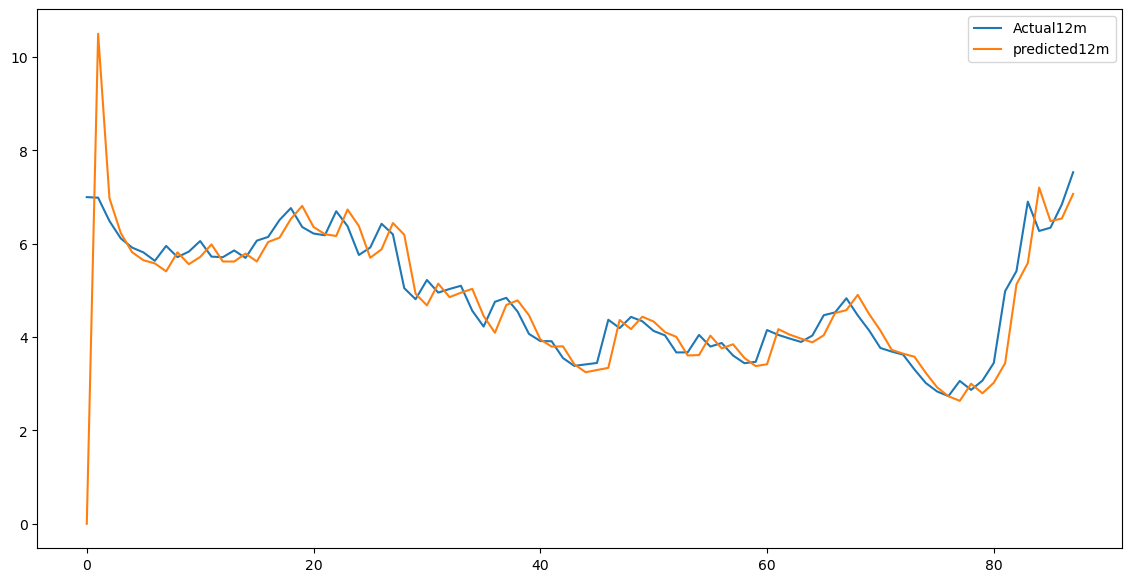

In [43]:
df2[["Actual12m","predicted12m"]].plot(figsize=(14, 7))